In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness        

from time import time

Using TensorFlow backend.


In [2]:
def time_measure(chrom, iters=50):
    '''
    Function tu mesure the training time of a model
    '''
    times = []
    for i in range(iters):
        ti = time()
        c.fitness()
        times.append(time() - ti)
    return times



### Test the capability of a neural network with a single layer

In [5]:
c = Cromosome([Layer(930, 'prelu', 0.654)])


# Fitness params
epochs = 75
batch_size = 256
verbose = 1
redu_plat = False
early_stop = True

# dataset params:
dataset = 'mnist'
classes = []

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, early_stop=early_stop)

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 930)               730050    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 930)               930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 930)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                9310      
Total params: 740,290
Trainable params: 740,290
Non-trainable params: 0
_________________________________________________________________
Trai

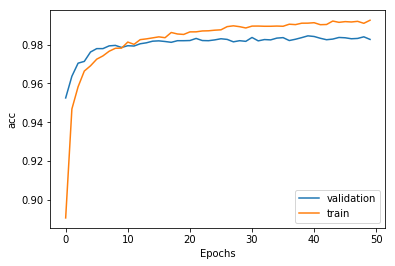

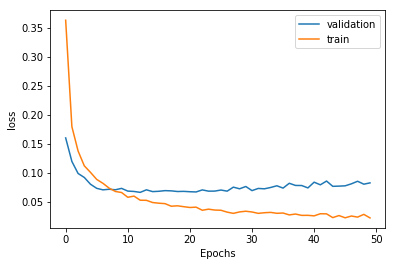

0.9845

In [6]:
c.fitness()

#### training time measurement when resetting VRAM memory

In [3]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])

# params:
dataset = 'mnist'
classes = [4, 9]
epochs = 2

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs)

t_with_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_with_reset), np.std(t_with_reset)))

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
mean time:	1.326
std:	1.473


In [4]:
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs, reset=False)

t_without_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_without_reset), np.std(t_without_reset)))

mean time:	2.145
std:	0.610


In [ ]:
from scipy import stats
t_value, p_value = stats.ttest_ind(t_without_reset, t_with_reset)
print("T-value: %0.3f " % t_value)
print("P-value: %0.3f " % p_value)

### Optimize a 2D - function with GA

Chromosome to minimize the fuction:

\begin{equation}
f(x) = x \cdot sin(4x) + 1.1  y \cdot sin(2y)
\end{equation}

In [4]:
class chrom:
    def __init__(self, x=0, y=0, mutation_prob=0.2):
        self.x = x
        self.y = y
        self.mut_prob = mutation_prob
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_individual(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_individual(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit
    
    def cross_val(self):
        return [self.fitness() for i in range(4)]

In [7]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5

c = chrom(mutation_prob=mut_prob)
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

winner, best_fit, ranking = generational.evolve(show=False)
print(best_fit)
print(winner)

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
-18.54115976408368
(9.027, 8.681)


-18.554716504097726 19.861786404025292


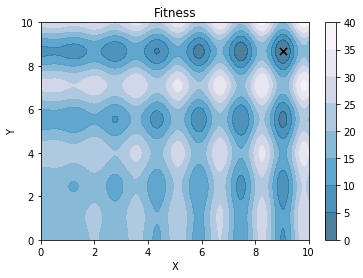

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    continue
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=50, marker='x')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitness')
ax.set_ylim((np.min(Y), np.max(Y)))
cbar = fig.colorbar(cs)
plt.show()

In [14]:
h = generational.population_history
def scatter_pop(h, generation, ax):
    for p in h[generation]:
        ax.scatter(p.x, p.y, c='g', label='min', s=100)
        
print(len(h), generations)

101 100


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((np.min(X), np.max(X)))
ax.set_ylim((np.min(Y), np.max(Y)))
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=100, marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
title = ax.set_title('')
plt.close(fig)
            
def animate2(i):
    ax.cla()
    ax.set_title('generation %s' % str(i).zfill(4))
    cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
    for i_, k_ in min_idxs:
        ax.scatter(x[k_], y[i_], c='k', label='min', s=100, marker='x')
    ax.set_xlim((np.min(X), np.max(X)))
    ax.set_ylim((np.min(Y), np.max(Y)))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    scatter_pop(h, i, ax)
    return

In [ ]:
anim = animation.FuncAnimation(fig,
                               animate2,
                               init_func=None,
                               frames=generations,
                               interval=100000)

# Set up formatting for the movie files
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/anim2.gif', writer=writer)

In [21]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5
iters = 100

c = chrom(mutation_prob=mut_prob)

ps = {'random':RandomParentSelector(), 'linealI':LinealOrder(), 'linealII':LinealOrderII(), 
      'wheel':WheelSelection(), 'tournament5': TournamentSelection(5), 'tournament3': TournamentSelection(3)}

all_fits = {}
for key in ps.keys():
    if key == 'wheel':
        continue
    print("Evaluating " + key + " parent selector")
    p = ps[key]
    all_fits[key] = []
    for i in range(iters):
        generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

        winner, best_fit, ranking = generational.evolve(show=False)
        all_fits[key].append(best_fit)



Evaluating randomparent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algor

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Evaluating tournament3parent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic 

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

In [22]:
for key, value in all_fits.items():
    print(key,"score: %0.4f  +-  %0.4f" % (np.mean(value), np.std(value)))

random score: -25.5032  +-  6.1512
linealI score: -26.0051  +-  5.4390
linealII score: -26.4715  +-  5.4950
tournament5 score: -27.9516  +-  5.6047
tournament3 score: -27.3675  +-  6.1080


### Lineal Order I

\begin{equation}
SelectionProb_i = \frac{Position_i}{\sum_{j}{Position_j}}
\end{equation}

### Lineal Order II

\begin{equation}
SelectionProb_i = \frac{N_{keep} - Position_i + 1}{\sum_{j}^{N_{keep}}{Position_j}}
\end{equation}

### Load variations of MNIST

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
def get_mnist_variations(folder, data):
    file_list = [f for f in os.listdir(folder) if f[-3:]!='zip']
    files = {'MB':'mnist',
             'MBI':'mnist_background_images',
             'MRB':'mnist_background_random',
             'MRD':'mnist_rotation_new',
             'MRDBI':'mnist_rotation_back_image_new'}
    T_mode = {'MB':False,
             'MBI':True,
             'MRB':True,
             'MRD':True,
             'MRDBI':True}
    assert data in files.keys()
    dataset = files[data]
    folder_datasets = os.path.join(folder, dataset)
    datasets = os.listdir(folder_datasets)
    file_train = os.path.join(folder_datasets, [d for d in datasets if 'train' in d][0])
    file_test  = os.path.join(folder_datasets, [d for d in datasets if 'test'  in d][0])

        
    def get_XY(file):
        with open(file, 'r') as f:
            X, Y = [], []
            for c, line in enumerate(f):
                array = line.split(' ')
                array = [float(l) for l in array if len(l)>0]
                array = np.array(array)
                Y.append(int(array[-1]))
                if T_mode[data]:
                    X.append(array[:-1].reshape(28, 28).T)
                else:
                    X.append(array[:-1].reshape(28, 28))
        return np.array(X), np.array(Y, dtype=np.int32)

    x_train, y_train = get_XY(file_train)
    x_test , y_test  = get_XY(file_test)
    return (x_train, y_train), (x_test, y_test)
    
    


In [230]:
folder = '../../../../../datasets/MNIST_variations'
data = 'MRDBI'
(x_train, y_train), (x_test, y_test) = get_mnist_variations(folder, data)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12000, 28, 28) (12000,)
(50000, 28, 28) (50000,)


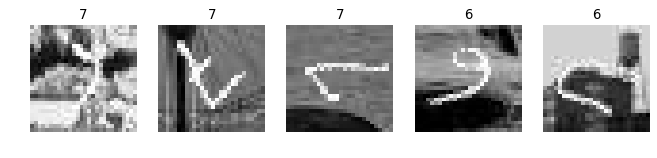

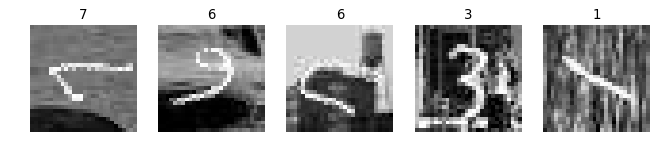

In [231]:
from matplotlib.pyplot import figure

N = 2
n = 5
for k in range(N):
    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(x_train[N * k + i,...], cmap='gray')
        plt.title(y_train[N * k + i])
        plt.axis('off')
plt.show()


### Train and evaluate models on MNIST's variants 

In [3]:
from utils.datamanager import DataManager
from utils.codification_cnn import NNLayer, ChromosomeCNN, CNNLayer, FitnessCNN      

from time import time

# Fitness params
epochs = 75
batch_size = 128
verbose = 1
redu_plat = False
early_stop = 15
warm_up_epochs= 5
base_lr = 0.001
smooth = 0.1
cosine_dec=True

data_folder = '../../../../../datasets/MNIST_variations'
classes = []

fitness = FitnessCNN()


----------  DATASET MB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
7296/9600 [=====================>........] - ETA: 0s - loss: 2.2983 - acc: 0.2242

/home/daniel/anaconda3/envs/python3/lib/python3.6/site-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (0.169572). Check your callbacks.
  % delta_t_median)


9600/9600 [==============================] - 1s 74us/step - loss: 2.2968 - acc: 0.2516 - val_loss: 2.2892 - val_acc: 0.3513
Epoch 2/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.2850 - acc: 0.3702 - val_loss: 2.2762 - val_acc: 0.3808
Epoch 3/75
9600/9600 [==============================] - 0s 24us/step - loss: 2.2737 - acc: 0.4059 - val_loss: 2.2634 - val_acc: 0.4271
Epoch 4/75
9600/9600 [==============================] - 0s 23us/step - loss: 2.2626 - acc: 0.4407 - val_loss: 2.2509 - val_acc: 0.4550
Epoch 5/75
9600/9600 [==============================] - 0s 22us/step - loss: 2.2517 - acc: 0.4746 - val_loss: 2.2385 - val_acc: 0.4929
Epoch 6/75
9600/9600 [==============================] - 0s 23us/step - loss: 2.2409 - acc: 0.4917 - val_loss: 2.2262 - val_acc: 0.5038
Epoch 7/75
9600/9600 [==============================] - 0s 24us/step - loss: 2.2302 - acc: 0.5275 - val_loss: 2.2142 - val_acc: 0.5279
Epoch 8/75
9600/9600 [==============================] - 0s 22us/st

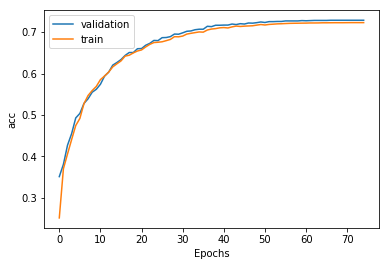

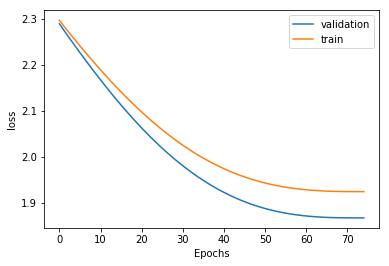

0.2712 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

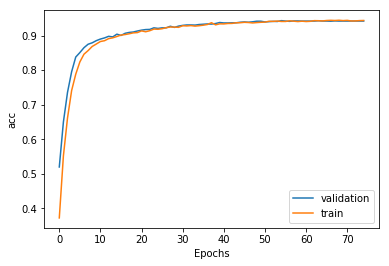

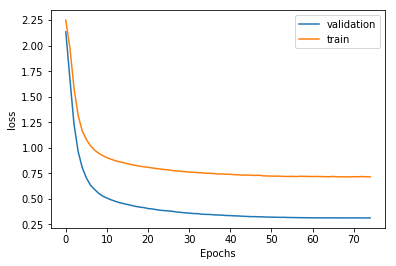

0.0567 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

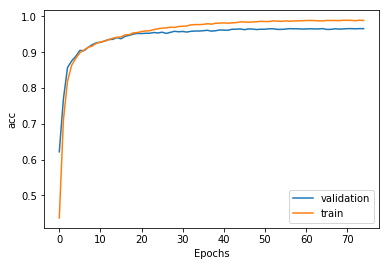

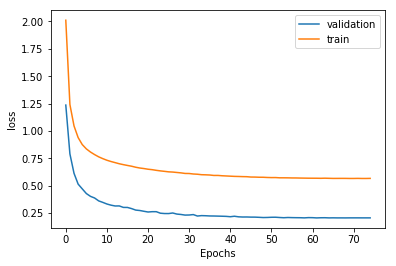

0.0342 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

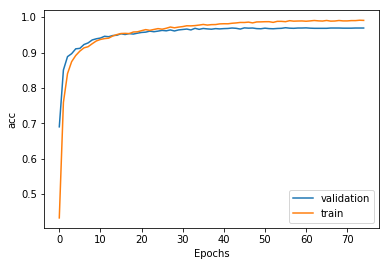

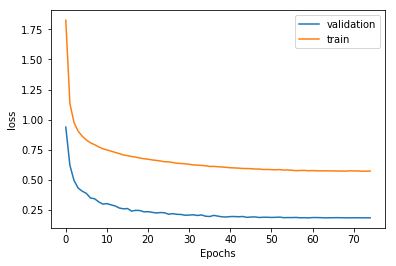

0.0300 in 1.1 min

----------  DATASET MBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 30us/step - loss: 2.3010 - acc: 0.1177 - val_loss: 2.2989 - val_acc: 0.1658
Epoch 2/75
9600/9600 [====

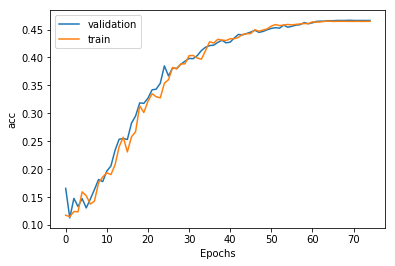

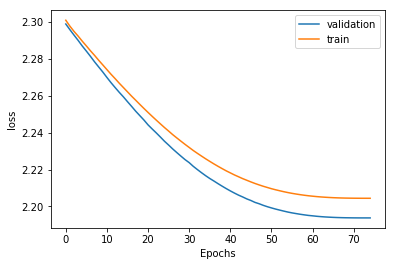

0.5333 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 40us/step - loss: 1.2228 - acc: 0.7326 - val_loss: 0.9572 - val_acc: 0.7200
Epoch 53/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.2220 - acc: 0.7311 - val_loss: 0.9570 - val_acc: 0.7188
Epoch 54/75
9600/9600 [==============================] - 0s 46us/step - loss: 1.2166 - acc: 0.7356 - val_loss: 0.9538 - val_acc: 0.7225
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.2201 - acc: 0.7342 - val_loss: 0.9543 - val_acc: 0.7196
Epoch 56/75
9600/9600 [==============================] - 0s 50us/step - loss: 1.2176 - acc: 0.7317 - val_loss: 0.9504 - val_acc: 0.7229
Epoch 57/75
9600/9600 [==============================] - 0s 40us/step - loss: 1.2160 - acc: 0.7315 - val_loss: 0.9495 - val_acc: 0.7208
Epoch 58/75
9600/9600 [==============================] - 0s 41us/step - loss: 1.2177 - acc: 0.7332 - val_loss: 0.9503 - val_acc: 0.7208
Epoch 59/75
9600/9600 [=========================

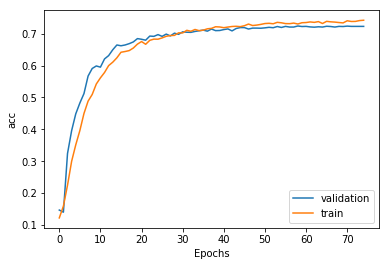

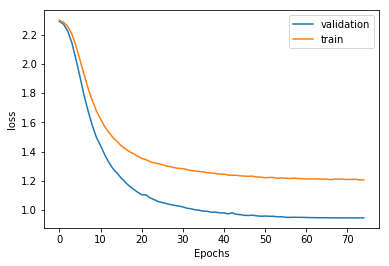

0.2758 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

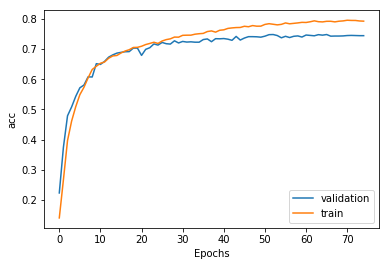

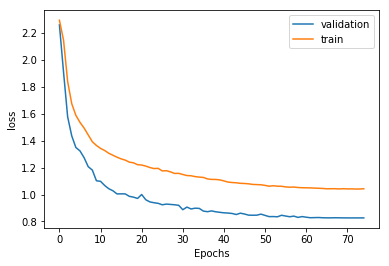

0.2517 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

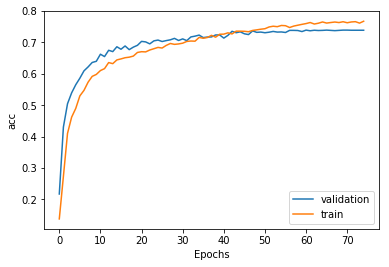

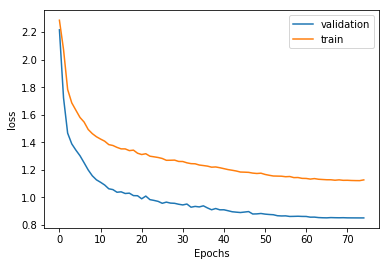

0.2612 in 1.1 min

----------  DATASET MRB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 30us/step - loss: 2.3012 - acc: 0.1109 - val_loss: 2.2993 - val_acc: 0.1021
Epoch 2/75
9600/9600 [====

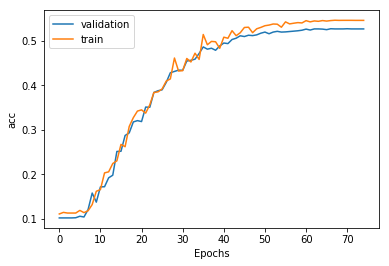

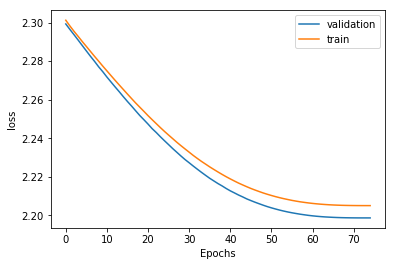

0.4733 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 40us/step - loss: 0.9649 - acc: 0.8475 - val_loss: 0.7050 - val_acc: 0.8096
Epoch 53/75
9600/9600 [==============================] - 0s 37us/step - loss: 0.9649 - acc: 0.8470 - val_loss: 0.7045 - val_acc: 0.8104
Epoch 54/75
9600/9600 [==============================] - 1s 58us/step - loss: 0.9618 - acc: 0.8492 - val_loss: 0.7037 - val_acc: 0.8088
Epoch 55/75
9600/9600 [==============================] - 0s 40us/step - loss: 0.9617 - acc: 0.8522 - val_loss: 0.7012 - val_acc: 0.8096
Epoch 56/75
9600/9600 [==============================] - 0s 40us/step - loss: 0.9600 - acc: 0.8501 - val_loss: 0.7013 - val_acc: 0.8087
Epoch 57/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.9599 - acc: 0.8491 - val_loss: 0.7016 - val_acc: 0.8104
Epoch 58/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.9570 - acc: 0.8508 - val_loss: 0.6989 - val_acc: 0.8092
Epoch 59/75
9600/9600 [=========================

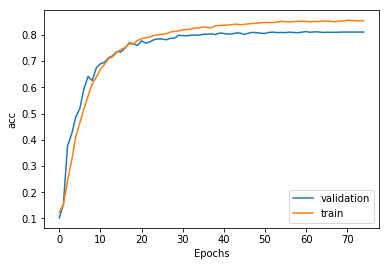

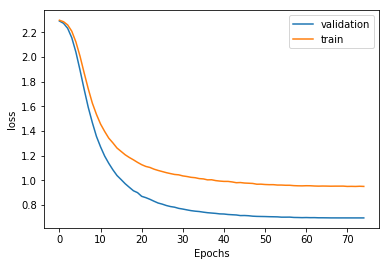

0.1875 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

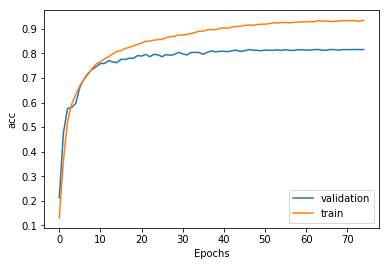

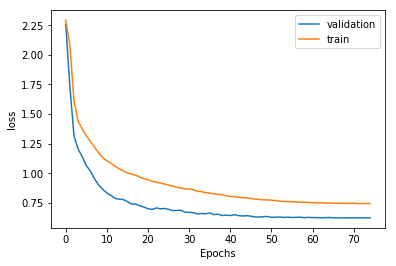

0.1842 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

/home/daniel/anaconda3/envs/python3/lib/python3.6/site-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (0.102333). Check your callbacks.
  % delta_t_median)


9600/9600 [==============================] - 1s 97us/step - loss: 2.2867 - acc: 0.1474 - val_loss: 2.2120 - val_acc: 0.2654
Epoch 2/75
9600/9600 [==============================] - 1s 59us/step - loss: 1.9930 - acc: 0.3290 - val_loss: 1.6332 - val_acc: 0.4637
Epoch 3/75
9600/9600 [==============================] - 1s 63us/step - loss: 1.6212 - acc: 0.4899 - val_loss: 1.2736 - val_acc: 0.5554
Epoch 4/75
9600/9600 [==============================] - 1s 59us/step - loss: 1.4722 - acc: 0.5591 - val_loss: 1.1890 - val_acc: 0.6050
Epoch 5/75
9600/9600 [==============================] - 1s 60us/step - loss: 1.4054 - acc: 0.6140 - val_loss: 1.1085 - val_acc: 0.6521
Epoch 6/75
9600/9600 [==============================] - 1s 65us/step - loss: 1.3402 - acc: 0.6403 - val_loss: 1.0174 - val_acc: 0.6913
Epoch 7/75
9600/9600 [==============================] - 1s 59us/step - loss: 1.2807 - acc: 0.6739 - val_loss: 0.9663 - val_acc: 0.7083
Epoch 8/75
9600/9600 [==============================] - 1s 60us/st

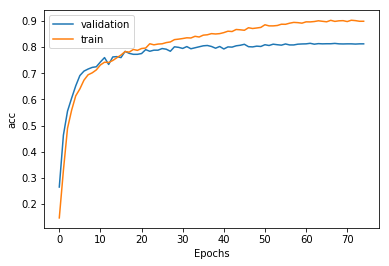

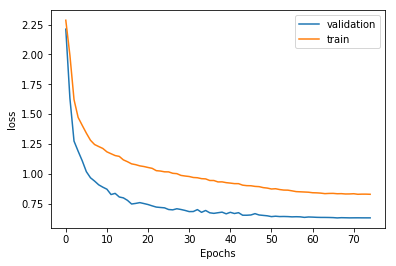

0.1854 in 1.2 min

----------  DATASET MRD  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 31us/step - loss: 2.3001 - acc: 0.1812 - val_loss: 2.2967 - val_acc: 0.2317
Epoch 2/75
9600/9600 [====

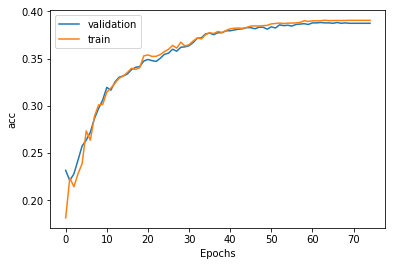

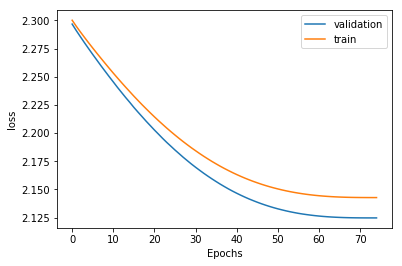

0.6117 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 1s 55us/step - loss: 1.4652 - acc: 0.5849 - val_loss: 1.2607 - val_acc: 0.5738
Epoch 53/75
9600/9600 [==============================] - 0s 37us/step - loss: 1.4673 - acc: 0.5834 - val_loss: 1.2596 - val_acc: 0.5733
Epoch 54/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.4649 - acc: 0.5795 - val_loss: 1.2587 - val_acc: 0.5717
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.4686 - acc: 0.5797 - val_loss: 1.2578 - val_acc: 0.5746
Epoch 56/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.4631 - acc: 0.5824 - val_loss: 1.2563 - val_acc: 0.5737
Epoch 57/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.4643 - acc: 0.5841 - val_loss: 1.2557 - val_acc: 0.5750
Epoch 58/75
9600/9600 [==============================] - 1s 64us/step - loss: 1.4603 - acc: 0.5875 - val_loss: 1.2551 - val_acc: 0.5729
Epoch 59/75
9600/9600 [=========================

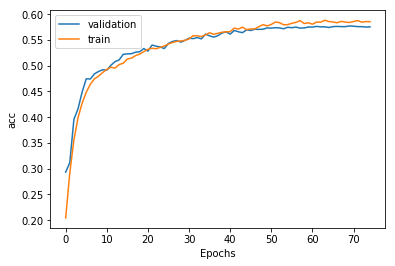

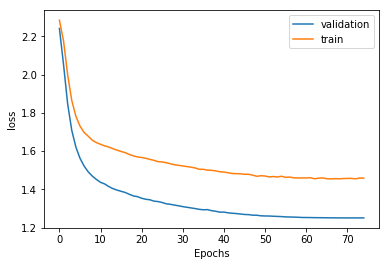

0.4229 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

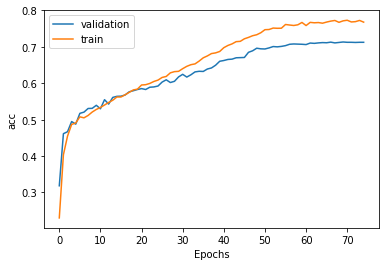

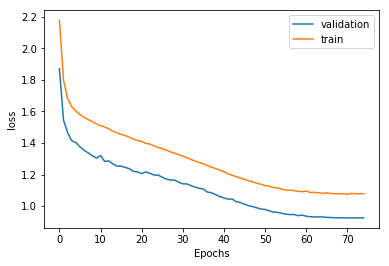

0.2871 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

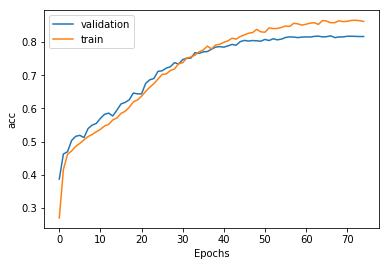

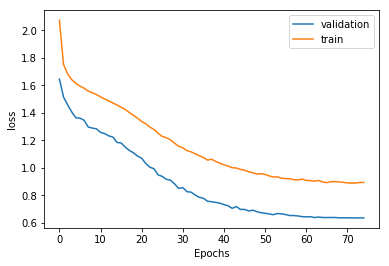

0.1813 in 1.2 min

----------  DATASET MRDBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 1s 77us/step - loss: 2.3016 - acc: 0.1165 - val_loss: 2.3019 - val_acc: 0.1154


/home/daniel/anaconda3/envs/python3/lib/python3.6/site-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (0.251777). Check your callbacks.
  % delta_t_median)


Epoch 2/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.3000 - acc: 0.1175 - val_loss: 2.3015 - val_acc: 0.1154
Epoch 3/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.2990 - acc: 0.1175 - val_loss: 2.3006 - val_acc: 0.1154
Epoch 4/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.2981 - acc: 0.1175 - val_loss: 2.2999 - val_acc: 0.1154
Epoch 5/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.2972 - acc: 0.1175 - val_loss: 2.2990 - val_acc: 0.1154
Epoch 6/75
9600/9600 [==============================] - 0s 20us/step - loss: 2.2964 - acc: 0.1175 - val_loss: 2.2980 - val_acc: 0.1154
Epoch 7/75
9600/9600 [==============================] - 0s 21us/step - loss: 2.2955 - acc: 0.1175 - val_loss: 2.2973 - val_acc: 0.1154
Epoch 8/75
9600/9600 [==============================] - 0s 20us/step - loss: 2.2946 - acc: 0.1175 - val_loss: 2.2963 - val_acc: 0.1158
Epoch 9/75
9600/9600 [==============================] -

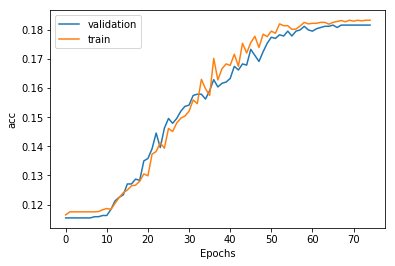

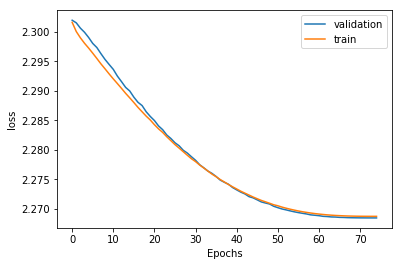

0.8183 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 1s 62us/step - loss: 1.8713 - acc: 0.3714 - val_loss: 1.7961 - val_acc: 0.3521
Epoch 53/75
9600/9600 [==============================] - 1s 60us/step - loss: 1.8699 - acc: 0.3705 - val_loss: 1.7947 - val_acc: 0.3487
Epoch 54/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8722 - acc: 0.3717 - val_loss: 1.7950 - val_acc: 0.3492
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8696 - acc: 0.3700 - val_loss: 1.7950 - val_acc: 0.3517
Epoch 56/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8689 - acc: 0.3700 - val_loss: 1.7948 - val_acc: 0.3500
Epoch 57/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8720 - acc: 0.3733 - val_loss: 1.7947 - val_acc: 0.3488
Epoch 58/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8709 - acc: 0.3701 - val_loss: 1.7954 - val_acc: 0.3525
Epoch 59/75
9600/9600 [=========================

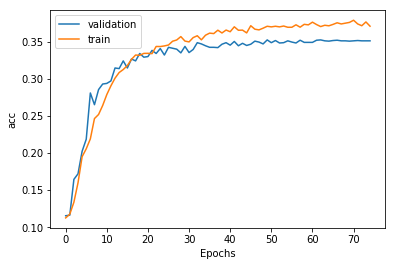

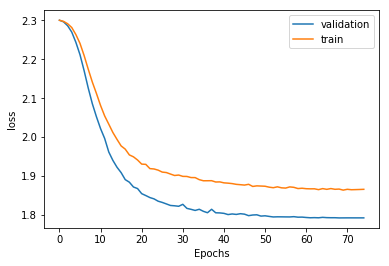

0.6471 in 0.7 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

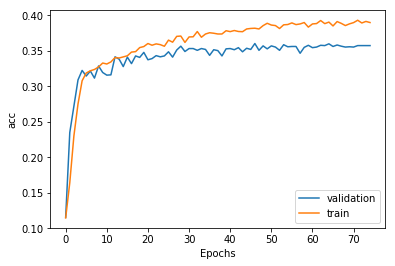

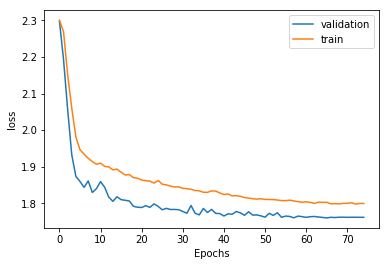

0.6396 in 0.7 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

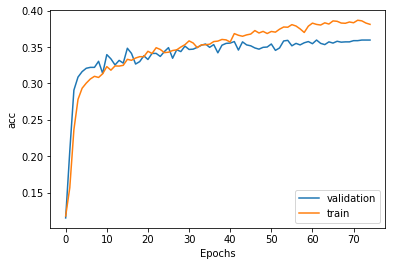

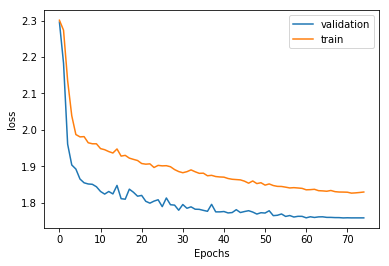

0.6404 in 1.0 min


	Training model:
best_mrdbi
CNN|F:99|K:(7,3)|A:leakyreLu|D:0.307|M:0
CNN|F:192|K:(5,6)|A:relu|D:0.271|M:0
CNN|F:96|K:(1,7)|A:leakyreLu|D:0.041|M:1
CNN|F:177|K:(1,3)|A:elu|D:0.161|M:1
CNN|F:177|K:(7,4)|A:relu|D:0.656|M:0
NN|U:286|A:elu|D:0.432
NN|U:411|A:sigmoid|D:0.527
NN|U:621|A:elu|D:0.491


CNN|F:99|K:(7,3)|A:leakyreLu|D:0.307|M:0
CNN|F:192|K:(5,6)|A:relu|D:0.271|M:0
CNN|F:96|K:(1,7)|A:leakyreLu|D:0.041|M:1
CNN|F:177|K:(1,3)|A:elu|D:0.161|M:1
CNN|F:177|K:(7,4)|A:relu|D:0.656|M:0
NN|U:286|A:elu|D:0.432
NN|U:411|A:sigmoid|D:0.527
NN|U:621|A:elu|D:0.491
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 99)        2178      
_________________________________________________________________
leaky_re_lu_

Epoch 27/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6758 - acc: 0.9390 - val_loss: 0.5498 - val_acc: 0.8421
Epoch 28/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6642 - acc: 0.9467 - val_loss: 0.5898 - val_acc: 0.8296
Epoch 29/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6508 - acc: 0.9506 - val_loss: 0.5831 - val_acc: 0.8342
Epoch 30/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6405 - acc: 0.9552 - val_loss: 0.5689 - val_acc: 0.8362
Epoch 31/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6341 - acc: 0.9572 - val_loss: 0.5662 - val_acc: 0.8337
Epoch 32/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6233 - acc: 0.9603 - val_loss: 0.5638 - val_acc: 0.8404
Epoch 33/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6238 - acc: 0.9623 - val_loss: 0.5610 - val_acc: 0.8438
Epoch 34/75
9600/9600 [=========================

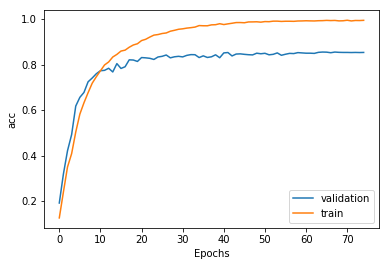

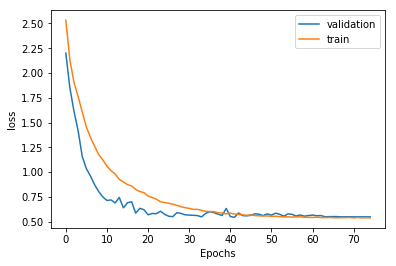

0.1450 in 54.8 min



In [2]:
logreg = ChromosomeCNN([],[], fitness)
simplest = ChromosomeCNN([], [NNLayer(830, 'prelu', 0.654)], fitness)
baseline = ChromosomeCNN([], [NNLayer(512, 'relu', 0.2), NNLayer(512, 'relu', 0.2)], fitness)
best = ChromosomeCNN([], [NNLayer(830, 'prelu', 0.654),
                          NNLayer(782, 'tanh', 0.166), NNLayer(28, 'elu', 0.062)], fitness)

l1 = CNNLayer(99, (7,3), 'leakyreLu', 0.307, 0)
l2 = CNNLayer(192, (5,6), 'relu', 0.271, 0)
l3 = CNNLayer(96, (1,7), 'leakyreLu', 0.041, 1)
l4 = CNNLayer(177, (1,3), 'elu', 0.161, 1)
l5 = CNNLayer(177, (7,4), 'relu', 0.656, 0)
l6 = NNLayer(286, 'elu', 0.432)
l7 = NNLayer(411, 'sigmoid', 0.527)
l8 = NNLayer(621, 'elu', 0.491)
best_mrdbi = ChromosomeCNN([l1,l2,l3,l4,l5], [l6, l7, l8], fitness)

models = {'logreg':logreg, 'simplest':simplest, 'baseline':baseline, 'best':best, 'best_mrdbi':best_mrdbi}
datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
results = {}

for dataset in datasets:
    print("-"*10 + "  DATASET %s  " % dataset + "-"*10)
    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    data = dm.load_data()
    fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, epochs=epochs, cosine_decay=cosine_dec,
                   early_stop=early_stop, warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)
    for tag, model in models.items():
        if tag=='best_mrdbi' and dataset!='MRDBI':
            continue
        print("\n\tTraining model:")
        print(tag)
        print(model, end='\n\n')
        score = model.fitness()
        results[(model.__repr__(), dataset)] = score

----------  DATASET MB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 33us/step - loss: 2.3021 - acc: 0.1890 - val_loss: 2.3011 - val_acc: 0.2171
Epoch 2/75
9600/9600 [========================

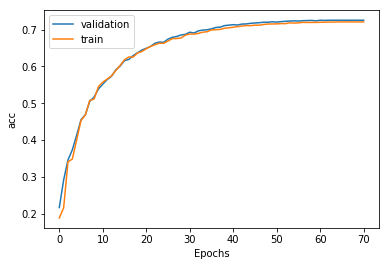

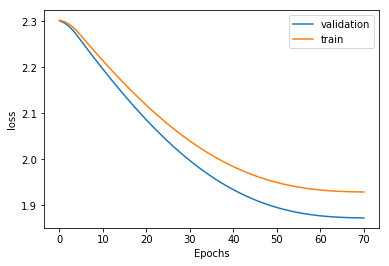

0.2746 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.7221 - acc: 0.9420 - val_loss: 0.3182 - val_acc: 0.9383
Epoch 53/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.7211 - acc: 0.9408 - val_loss: 0.3186 - val_acc: 0.9383
Epoch 54/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.7182 - acc: 0.9435 - val_loss: 0.3175 - val_acc: 0.9379
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 0.7181 - acc: 0.9423 - val_loss: 0.3161 - val_acc: 0.9392
Epoch 56/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.7198 - acc: 0.9397 - val_loss: 0.3154 - val_acc: 0.9383
Epoch 57/75
9600/9600 [==============================] - 0s 46us/step - loss: 0.7161 - acc: 0.9421 - val_loss: 0.3147 - val_acc: 0.9392
Epoch 58/75
9600/9600 [==============================] - 0s 43us/step - loss: 0.7154 - acc: 0.9424 - val_loss: 0.3146 - val_acc: 0.9387
Epoch 59/75
9600/9600 [=========================

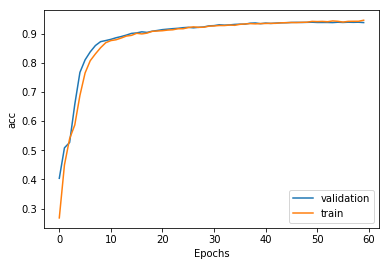

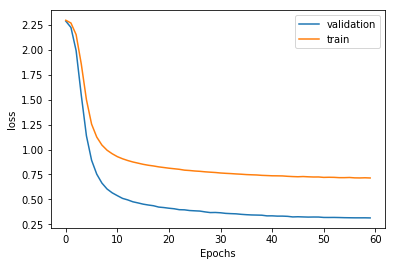

0.0608 in 0.7 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

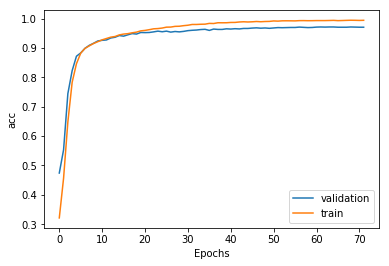

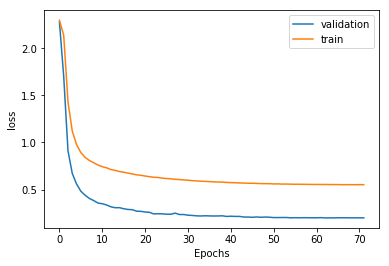

0.0288 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

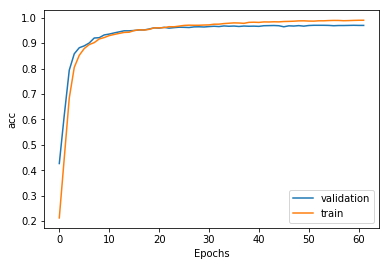

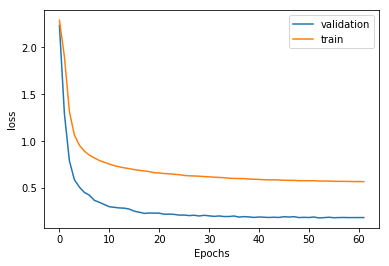

0.0300 in 1.0 min

----------  DATASET MBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 31us/step - loss: 2.3024 - acc: 0.1161 - val_loss: 2.3022 - val_acc: 0.1183
Epoch 2/75
9600/9600 [====

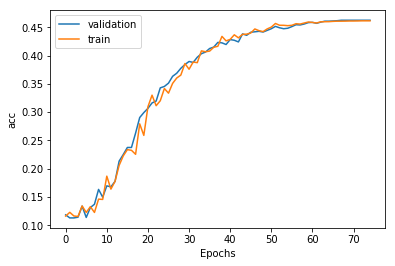

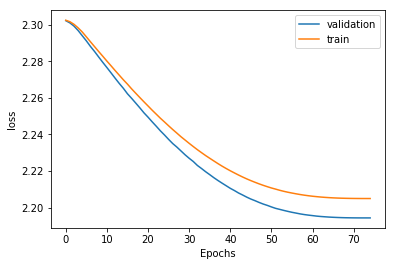

0.5375 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.2160 - acc: 0.7357 - val_loss: 0.9511 - val_acc: 0.7158
Epoch 53/75
9600/9600 [==============================] - 0s 48us/step - loss: 1.2166 - acc: 0.7355 - val_loss: 0.9501 - val_acc: 0.7204
Epoch 54/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.2145 - acc: 0.7357 - val_loss: 0.9491 - val_acc: 0.7208
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.2152 - acc: 0.7319 - val_loss: 0.9481 - val_acc: 0.7200
Epoch 56/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.2110 - acc: 0.7368 - val_loss: 0.9460 - val_acc: 0.7225
Epoch 57/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.2091 - acc: 0.7393 - val_loss: 0.9456 - val_acc: 0.7233
Epoch 58/75
9600/9600 [==============================] - 0s 40us/step - loss: 1.2113 - acc: 0.7368 - val_loss: 0.9454 - val_acc: 0.7233
Epoch 59/75
9600/9600 [=========================

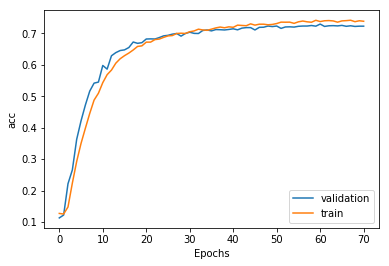

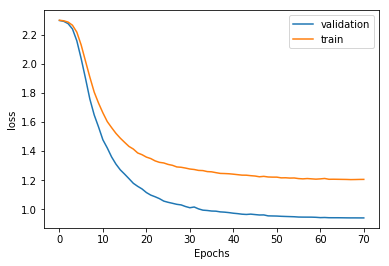

0.2704 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

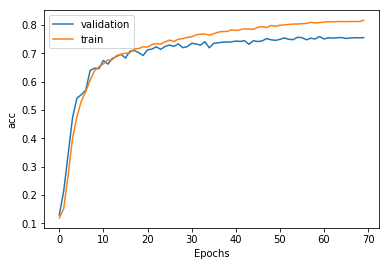

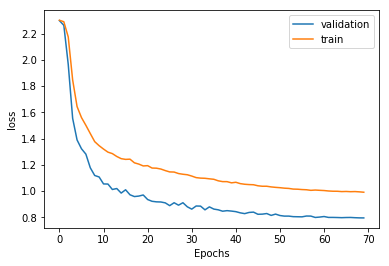

0.2413 in 0.7 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

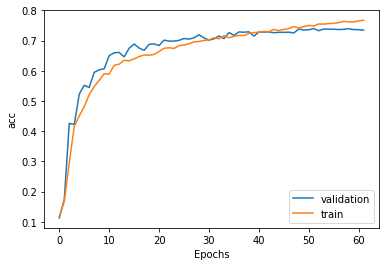

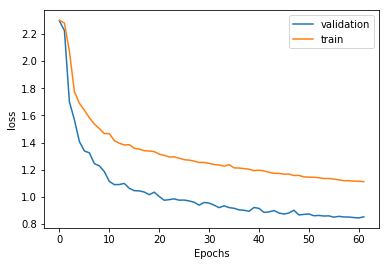

0.2600 in 0.9 min

----------  DATASET MRB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 32us/step - loss: 2.3024 - acc: 0.1137 - val_loss: 2.3022 - val_acc: 0.1025
Epoch 2/75
9600/9600 [====

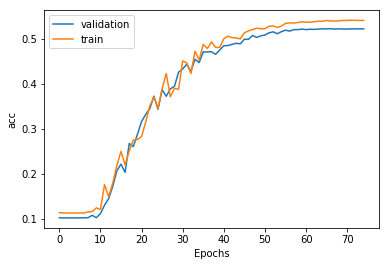

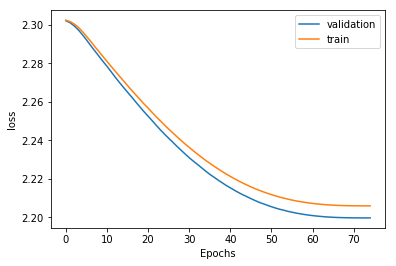

0.4771 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 38us/step - loss: 0.9633 - acc: 0.8465 - val_loss: 0.7007 - val_acc: 0.8088
Epoch 53/75
9600/9600 [==============================] - 0s 40us/step - loss: 0.9624 - acc: 0.8493 - val_loss: 0.7002 - val_acc: 0.8108
Epoch 54/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.9569 - acc: 0.8532 - val_loss: 0.6983 - val_acc: 0.8092
Epoch 55/75
9600/9600 [==============================] - 0s 39us/step - loss: 0.9596 - acc: 0.8483 - val_loss: 0.6971 - val_acc: 0.8067
Epoch 56/75
9600/9600 [==============================] - 0s 42us/step - loss: 0.9557 - acc: 0.8534 - val_loss: 0.6963 - val_acc: 0.8083
Epoch 57/75
9600/9600 [==============================] - 0s 40us/step - loss: 0.9582 - acc: 0.8518 - val_loss: 0.6963 - val_acc: 0.8087
Epoch 58/75
9600/9600 [==============================] - 0s 42us/step - loss: 0.9548 - acc: 0.8558 - val_loss: 0.6952 - val_acc: 0.8087
Epoch 59/75
9600/9600 [=========================

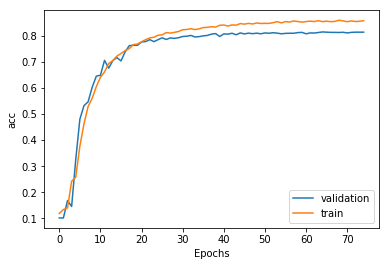

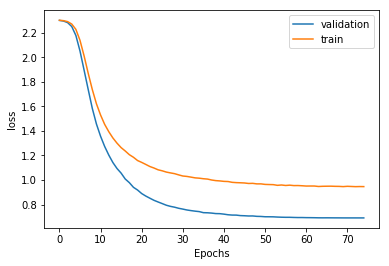

0.1863 in 0.8 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

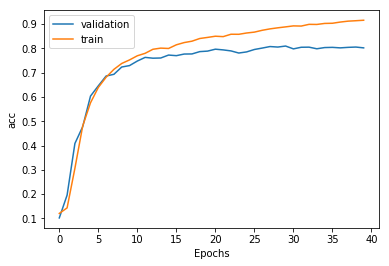

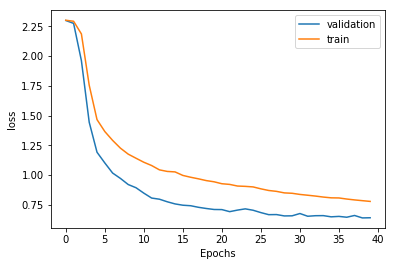

0.1908 in 0.5 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

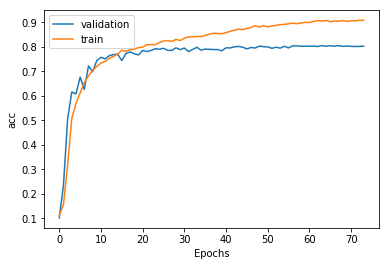

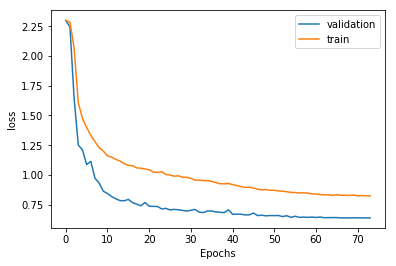

0.1946 in 1.1 min

----------  DATASET MRD  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 31us/step - loss: 2.3024 - acc: 0.1171 - val_loss: 2.3020 - val_acc: 0.1883
Epoch 2/75
9600/9600 [====

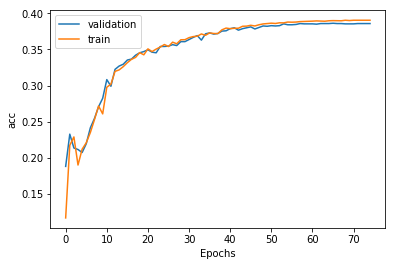

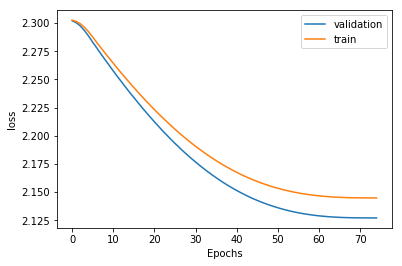

0.6138 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

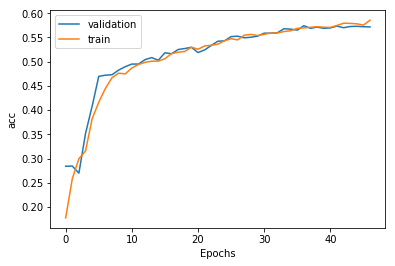

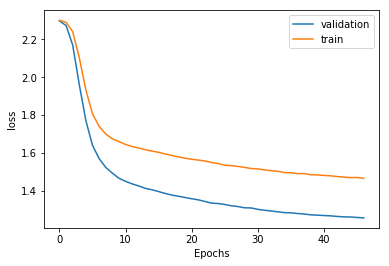

0.4258 in 0.5 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

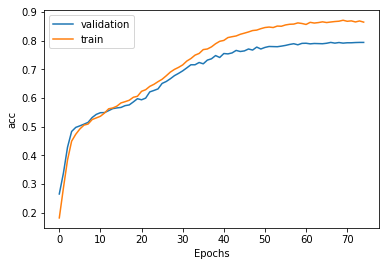

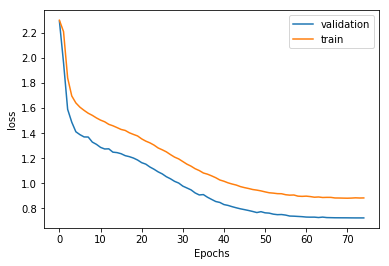

0.2067 in 0.8 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

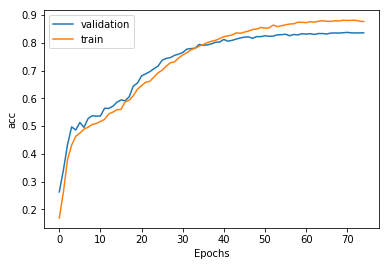

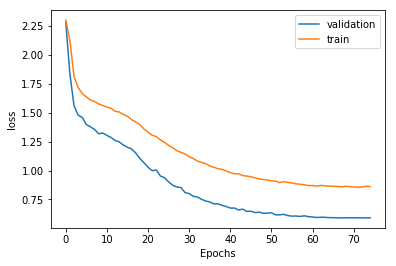

0.1625 in 1.2 min

----------  DATASET MRDBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 0s 30us/step - loss: 2.3025 - acc: 0.1051 - val_loss: 2.3025 - val_acc: 0.1029
Epoch 2/75
9600/9600 [==

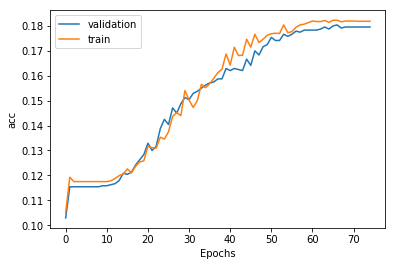

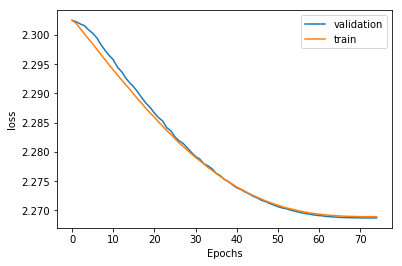

0.8196 in 0.4 min


	Training model:
simplest
NN|U:830|A:prelu|D:0.654


NN|U:830|A:prelu|D:0.654
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable 

Epoch 52/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.8733 - acc: 0.3717 - val_loss: 1.7985 - val_acc: 0.3467
Epoch 53/75
9600/9600 [==============================] - 0s 46us/step - loss: 1.8724 - acc: 0.3709 - val_loss: 1.7951 - val_acc: 0.3446
Epoch 54/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8719 - acc: 0.3720 - val_loss: 1.7954 - val_acc: 0.3454
Epoch 55/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8710 - acc: 0.3689 - val_loss: 1.7971 - val_acc: 0.3433
Epoch 56/75
9600/9600 [==============================] - 0s 39us/step - loss: 1.8697 - acc: 0.3697 - val_loss: 1.7947 - val_acc: 0.3458
Epoch 57/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8692 - acc: 0.3749 - val_loss: 1.7940 - val_acc: 0.3450
Epoch 58/75
9600/9600 [==============================] - 0s 38us/step - loss: 1.8691 - acc: 0.3723 - val_loss: 1.7952 - val_acc: 0.3458
Epoch 59/75
9600/9600 [=========================

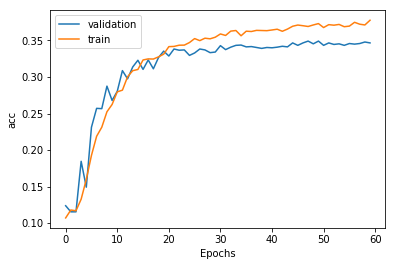

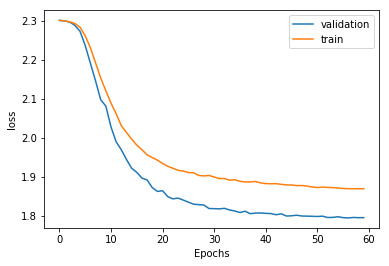

0.6508 in 0.6 min


	Training model:
baseline
NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200


NN|U:512|A:relu|D:0.200
NN|U:512|A:relu|D:0.200
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)            

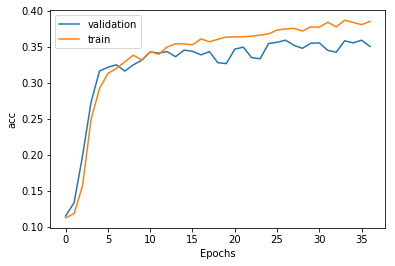

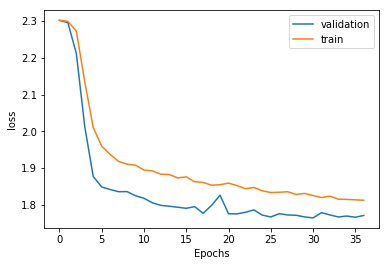

0.6404 in 0.4 min


	Training model:
best
NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062


NN|U:830|A:prelu|D:0.654
NN|U:782|A:tanh|D:0.166
NN|U:28|A:elu|D:0.062
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (D

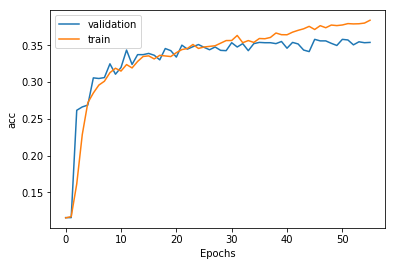

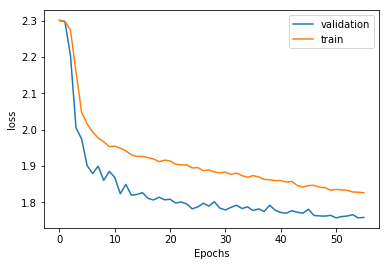

0.6417 in 0.8 min


	Training model:
best_mrdbi
CNN|F:99|K:(7,3)|A:leakyreLu|D:0.307|M:0
CNN|F:192|K:(5,6)|A:relu|D:0.271|M:0
CNN|F:96|K:(1,7)|A:leakyreLu|D:0.041|M:1
CNN|F:177|K:(1,3)|A:elu|D:0.161|M:1
CNN|F:177|K:(7,4)|A:relu|D:0.656|M:0
NN|U:286|A:elu|D:0.432
NN|U:411|A:sigmoid|D:0.527
NN|U:621|A:elu|D:0.491


CNN|F:99|K:(7,3)|A:leakyreLu|D:0.307|M:0
CNN|F:192|K:(5,6)|A:relu|D:0.271|M:0
CNN|F:96|K:(1,7)|A:leakyreLu|D:0.041|M:1
CNN|F:177|K:(1,3)|A:elu|D:0.161|M:1
CNN|F:177|K:(7,4)|A:relu|D:0.656|M:0
NN|U:286|A:elu|D:0.432
NN|U:411|A:sigmoid|D:0.527
NN|U:621|A:elu|D:0.491
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 99)        2178      
_________________________________________________________________
leaky_re_lu_

Epoch 27/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6953 - acc: 0.9327 - val_loss: 0.5988 - val_acc: 0.8237
Epoch 28/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6921 - acc: 0.9339 - val_loss: 0.5536 - val_acc: 0.8404
Epoch 29/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6742 - acc: 0.9394 - val_loss: 0.5607 - val_acc: 0.8337
Epoch 30/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6737 - acc: 0.9424 - val_loss: 0.5659 - val_acc: 0.8337
Epoch 31/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6572 - acc: 0.9460 - val_loss: 0.5573 - val_acc: 0.8404
Epoch 32/75
9600/9600 [==============================] - 41s 4ms/step - loss: 0.6541 - acc: 0.9481 - val_loss: 0.5642 - val_acc: 0.8321
Epoch 33/75
9600/9600 [==============================] - 40s 4ms/step - loss: 0.6338 - acc: 0.9572 - val_loss: 0.5774 - val_acc: 0.8342
Epoch 34/75
9600/9600 [=========================

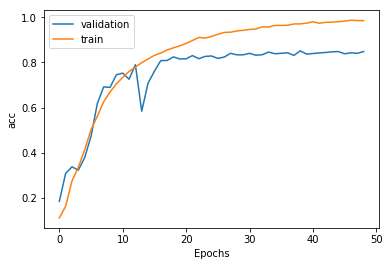

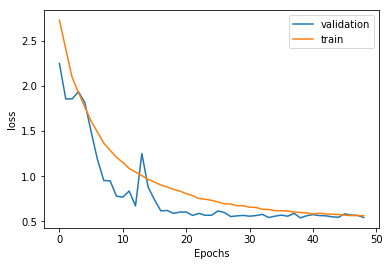

0.1487 in 37.2 min



In [4]:
logreg = ChromosomeCNN([],[], fitness)
simplest = ChromosomeCNN([], [NNLayer(830, 'prelu', 0.654)], fitness)
baseline = ChromosomeCNN([], [NNLayer(512, 'relu', 0.2), NNLayer(512, 'relu', 0.2)], fitness)
best = ChromosomeCNN([], [NNLayer(830, 'prelu', 0.654),
                          NNLayer(782, 'tanh', 0.166), NNLayer(28, 'elu', 0.062)], fitness)

l1 = CNNLayer(99, (7,3), 'leakyreLu', 0.307, 0)
l2 = CNNLayer(192, (5,6), 'relu', 0.271, 0)
l3 = CNNLayer(96, (1,7), 'leakyreLu', 0.041, 1)
l4 = CNNLayer(177, (1,3), 'elu', 0.161, 1)
l5 = CNNLayer(177, (7,4), 'relu', 0.656, 0)
l6 = NNLayer(286, 'elu', 0.432)
l7 = NNLayer(411, 'sigmoid', 0.527)
l8 = NNLayer(621, 'elu', 0.491)
best_mrdbi = ChromosomeCNN([l1,l2,l3,l4,l5], [l6, l7, l8], fitness)

            
l1 = CNNLayer(136, (7,1), 'sigmoid', 0.057, 0)
l2 = CNNLayer(157, (7,6), 'prelu', 0.454, 0)
l3 = CNNLayer(71, (3,1), 'sigmoid', 0.526, 0)
l4 = CNNLayer(106, (3,7), 'elu', 0.949, 0)
l5 = NNLayer(218, 'sigmoid', 0.385)
l6 = NNLayer(816, 'elu', 0.199)
best_mrd = ChromosomeCNN([l1,l2,l3,l4], [l5,l6], fitness)

models = {'logreg':logreg, 'simplest':simplest, 'baseline':baseline, 'best':best, 'best_mrdbi':best_mrdbi}
datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
results = {}

for dataset in datasets:
    print("-"*10 + "  DATASET %s  " % dataset + "-"*10)
    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    data = dm.load_data()
    fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, epochs=epochs, cosine_decay=cosine_dec,
                   early_stop=early_stop, warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)
    for tag, model in models.items():
        if tag=='best_mrdbi' and dataset!='MRDBI':
            continue
        print("\n\tTraining model:")
        print(tag)
        print(model, end='\n\n')
        score = model.fitness()
        results[(model.__repr__(), dataset)] = score

### Ploting forbbiden graphics

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from utils.datamanager import DataManager
from utils.codification_cnn import NNLayer, ChromosomeCNN, CNNLayer, FitnessCNN      
from time import time

Using TensorFlow backend.


In [54]:
filename = './delete/history_mrd'
infile = open(filename, 'rb')
h = pickle.load(infile)
infile.close()
h = h[:, 0:21]




In [55]:
def show_history_(h, zoom=False, maximize=0, name=''):
    colors = np.array([[31, 119, 180], [255, 127, 14]]) / 255.
    epochs = np.linspace(1, h.shape[1], h.shape[1])
    bests = [np.min(h, axis=0), np.max(h, axis=0)][maximize]
    plt.figure(figsize=(10, 5))
    s = 6
    for a in h:
        plt.scatter(epochs, a, s=s, color='k', alpha=1, marker='.')
    plt.scatter(epochs, bests, color=colors[0], s=s * 5, marker='*')
    plt.plot(epochs, np.mean(h, axis=0), color=colors[1], lw=1.5, label='mean', linestyle='--')
    plt.plot(epochs, bests, color=colors[0], lw=1.5, label='best', linestyle='--')
    if zoom:
        last_gen = h[:, -1]
        lim_inf_y = [np.min(last_gen), np.mean(last_gen)][maximize]
        lim_sup_y = [np.mean(last_gen), np.max(last_gen)][maximize]
        lim_inf_y = lim_inf_y - (lim_sup_y - lim_inf_y) * 0.1
        lim_sup_y = lim_sup_y + (lim_sup_y - lim_inf_y) * 0.1
        plt.ylim(lim_inf_y, lim_sup_y)
    plt.grid()
    plt.legend()
    plt.ylabel('Fitness')
    plt.xlabel('Generations')
    if name != '':
        plt.savefig(name)
    plt.show()

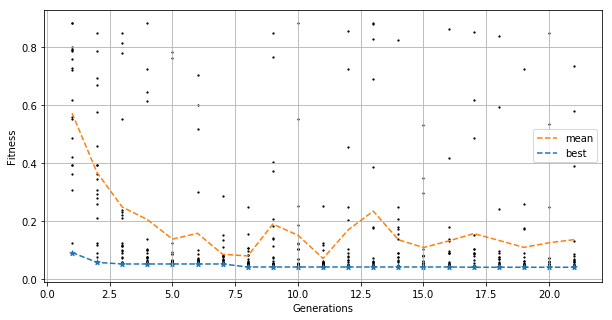

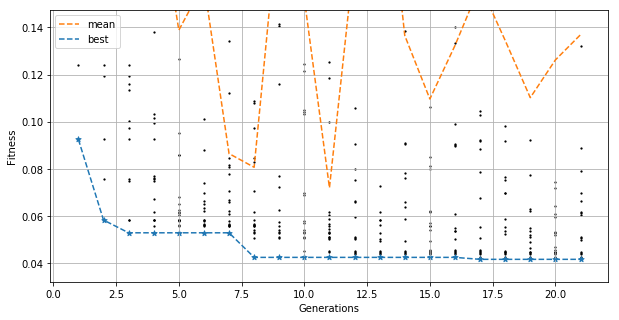

In [56]:
show_history_(h, name='./delete/mrd_fitness')
show_history_(h, zoom=True, name='./delete/mrd_fitness_zoom')

In [2]:
filename = './delete/history_fitness_mrd'
infile = open(filename, 'rb')
hf = pickle.load(infile)
infile.close()

FileNotFoundError: [Errno 2] No such file or directory: './delete/history_fitness_mrd'

In [72]:
min_v = 1
min_v2 = 1
winner = None
for k,v in hf.items():
    if v < min_v:
        min_v = v
        winner = k
    elif v < min_v2:
        min_v2 = v
        winner2 = k
print(min_v)
print(k)
print()
print(min_v2)
print(winner2)

for k, v in hf.items():
    if v < 0.05:
        print(v)
        print(k)
        print()

0.041666667461395246
CNN|F:136|K:(7,1)|A:sigmoid|D:0.057|M:0
CNN|F:157|K:(7,6)|A:prelu|D:0.454|M:0
CNN|F:71|K:(3,1)|A:sigmoid|D:0.526|M:0
CNN|F:106|K:(3,7)|A:elu|D:0.949|M:0
NN|U:218|A:sigmoid|D:0.385
NN|U:816|A:elu|D:0.199


0.042083332538604745
CNN|F:198|K:(7,7)|A:relu|D:0.447|M:0
CNN|F:100|K:(5,3)|A:prelu|D:0.046|M:0
CNN|F:83|K:(5,5)|A:prelu|D:0.423|M:0
CNN|F:76|K:(3,3)|A:sigmoid|D:0.911|M:0
NN|U:824|A:elu|D:0.149
NN|U:557|A:elu|D:0.417
NN|U:884|A:leakyreLu|D:0.730

0.04249999999999998
CNN|F:187|K:(7,7)|A:relu|D:0.399|M:0
CNN|F:155|K:(7,6)|A:prelu|D:0.470|M:0
CNN|F:58|K:(5,7)|A:prelu|D:0.384|M:0
CNN|F:81|K:(5,5)|A:sigmoid|D:0.655|M:0
NN|U:741|A:relu|D:0.385
NN|U:13|A:elu|D:0.410


0.04500000000000004
CNN|F:187|K:(7,7)|A:relu|D:0.399|M:0
CNN|F:184|K:(7,6)|A:prelu|D:0.497|M:0
CNN|F:90|K:(3,5)|A:prelu|D:0.408|M:0
CNN|F:100|K:(5,3)|A:sigmoid|D:0.817|M:0
NN|U:790|A:relu|D:0.439
NN|U:68|A:elu|D:0.456
NN|U:875|A:elu|D:0.530


0.04458333253860469
CNN|F:187|K:(7,7)|A:relu|D:0.399|M:0
CNN|F:1

In [3]:
# Fitness params
epochs = 75
batch_size = 128
verbose = 1
redu_plat = False
early_stop = 20
warm_up_epochs= 5
base_lr = 0.001
smooth = 0
cosine_dec = True

data_folder = '../../../../../datasets/MNIST_variations'
classes = []

fitness = FitnessCNN()

l1 = CNNLayer(187, (7,7), 'relu', 0.399, 0)
l2 = CNNLayer(155, (7,5), 'prelu', 0.47, 0)
l3 = CNNLayer(58, (5,7), 'prelu', 0.384, 0)
l4 = CNNLayer(81, (5,5), 'sigmoid', 0.655, 0)
l5 = NNLayer(741, 'relu', 0.385)
l6 = NNLayer(13, 'elu', 0.41)
best_mrd = ChromosomeCNN([l1,l2,l3,l4], [l5,l6], fitness)


l1 = CNNLayer(99, (7,3), 'leakyreLu', 0.307, 0)
l2 = CNNLayer(192, (5,6), 'relu', 0.271, 0)
l3 = CNNLayer(96, (1,7), 'leakyreLu', 0.041, 1)
l4 = CNNLayer(177, (1,3), 'elu', 0.161, 1)
l5 = CNNLayer(177, (7,4), 'relu', 0.656, 0)
l6 = NNLayer(286, 'elu', 0.432)
l7 = NNLayer(411, 'sigmoid', 0.527)
l8 = NNLayer(621, 'elu', 0.491)
best_mrdbi = ChromosomeCNN([l1,l2,l3,l4,l5], [l6, l7, l8], fitness)

dataset = 'MRDBI'
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, epochs=epochs, cosine_decay=cosine_dec,
               early_stop=early_stop, warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


Training... 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 187)       9350      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 187)       748       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 187)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 155)       1014630   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 28, 28, 155)       121520    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 155)       620    

Epoch 38/75
9600/9600 [==============================] - 67s 7ms/step - loss: 0.1780 - acc: 0.9518 - val_loss: 0.3125 - val_acc: 0.9438
Epoch 39/75
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1779 - acc: 0.9575 - val_loss: 0.3310 - val_acc: 0.9387
Epoch 40/75
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1708 - acc: 0.9557 - val_loss: 0.3930 - val_acc: 0.9329
Epoch 41/75
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1886 - acc: 0.9533 - val_loss: 0.3407 - val_acc: 0.9333
Epoch 42/75
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1853 - acc: 0.9510 - val_loss: 0.3536 - val_acc: 0.9350
Epoch 43/75
9600/9600 [==============================] - 66s 7ms/step - loss: 0.1668 - acc: 0.9584 - val_loss: 0.3107 - val_acc: 0.9421
Epoch 44/75
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1616 - acc: 0.9581 - val_loss: 0.3414 - val_acc: 0.9408
Epoch 45/75
9600/9600 [=========================

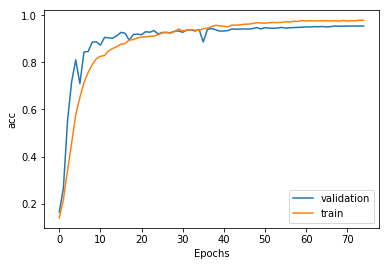

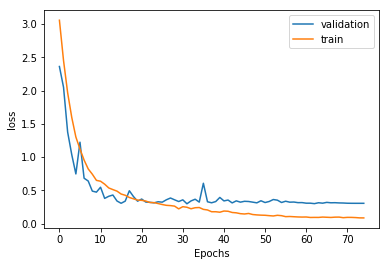

0.0454 in 85.0 min



In [4]:
score = best_mrd.fitness()

CNN|F:136|K:(7,1)|A:sigmoid|D:0.057|M:0
CNN|F:157|K:(7,6)|A:prelu|D:0.454|M:0
CNN|F:71|K:(3,1)|A:sigmoid|D:0.526|M:0
CNN|F:106|K:(3,7)|A:elu|D:0.500|M:0
NN|U:218|A:sigmoid|D:0.385
NN|U:816|A:elu|D:0.199
Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 136)       1088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 136)       544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 136)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 157)       896941    
___________________________________________________________

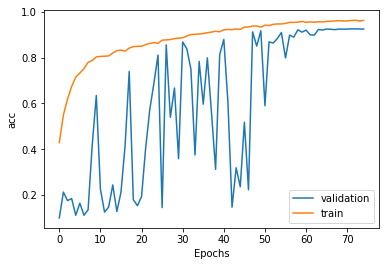

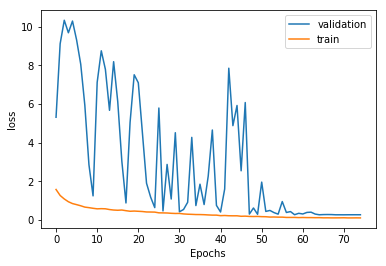

0.0737 in 68.4 min



In [3]:
l1 = CNNLayer(136, (7,1), 'sigmoid', 0.057, 0)
l2 = CNNLayer(157, (7,6), 'prelu', 0.454, 0)
l3 = CNNLayer(71, (3,1), 'sigmoid', 0.526, 0)
l4 = CNNLayer(106, (3,7), 'elu', 0.5, 0)
l5 = NNLayer(218, 'sigmoid', 0.385)
l6 = NNLayer(816, 'elu', 0.199)


best_mrd = ChromosomeCNN([l1,l2,l3,l4], [l5,l6], fitness)

score = best_mrd.fitness()

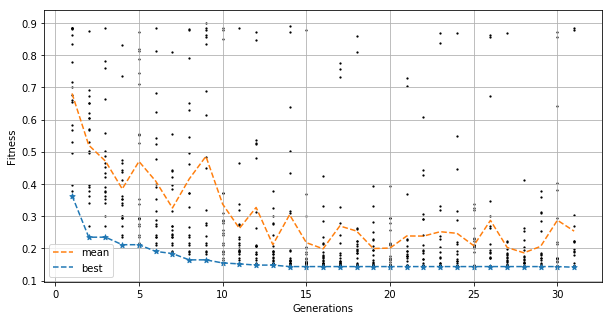

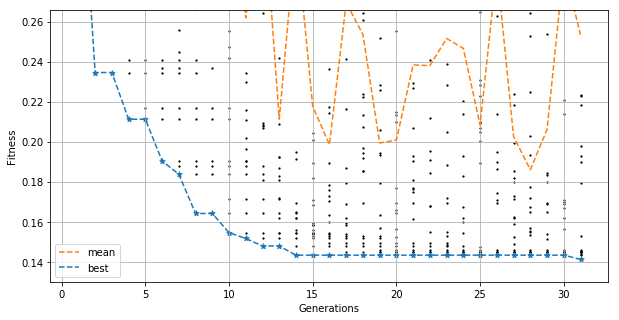

In [59]:
filename = './delete/history_mrdbi'
infile = open(filename, 'rb')
h = pickle.load(infile)
infile.close()
show_history_(h, name='./delete/mrdbi_fitness')
show_history_(h, zoom=True, name='./delete/mrdbi_fitness_zoom')

In [58]:
import random

def gauss_mutation(val, max_val, min_val, int_=True):
    m = 0
    s = (max_val - min_val) / 10.
    new_val = val + random.gauss(m, s)
    if int_:
        new_val = int(new_val)
    if new_val < min_val:
        new_val = 2 * min_val - new_val
    elif new_val > max_val:
        new_val = max_val - (new_val - max_val)
    if new_val > max_val or new_val < min_val:
        new_val = gauss_mutation(val, max_val, min_val, int_)
    return new_val

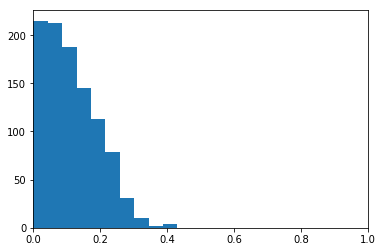

In [60]:
lim = [0,1]
v = [gauss_mutation(0.1, lim[1], lim[0], int_=False) for i in range(1000)]
plt.hist(v)
plt.xlim(lim)

plt.show()

In [25]:
plt.hist?